In [1]:
import os
import numpy as np
import pandas as pd

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split, ParameterGrid
from sklearn.metrics.pairwise import cosine_similarity
from scipy.stats import pearsonr

import warnings
warnings.filterwarnings(action = 'ignore')

import pickle

import matplotlib.pyplot as plt
import seaborn as sns

# 데이터 불러오기
ratings = pd.read_csv('/home/ryu/thesis/data/amazon/Amazon_ratings.csv')
reviews = pd.read_csv('/home/ryu/thesis/data/amazon/Amazon_reviews.csv')

ratings = ratings[['item_id', 'user_id', 'rating']]
reviews = reviews[['item_id', 'user_id', 'text']]

In [7]:
# 데이터 분할을 보장하기 위해 3개 이하로 평가한 사용자의 데이터는 콜드 스타트(Cold Start) 사례로 간주 하고 제거
cnt = ratings.groupby('user_id').count()['rating']
# cnt[cnt<=3] # 9.065%
keys = cnt[cnt>3].keys()
ratings = ratings[ratings['user_id'].isin(keys)]
ratings.shape

(241861, 3)

In [8]:
# 리뷰 임베딩 데이터 불러오기
with open('/home/ryu/thesis/real_amazon/additional_var/sbert_emb.pickle', 'rb') as f:
    embeddings = pickle.load(f)

In [9]:
emb = pd.DataFrame(embeddings)

In [10]:
data = pd.merge(ratings, reviews, how='left', left_on=['user_id', 'item_id'], right_on=['user_id', 'item_id'])
data = pd.concat([data, emb], axis=1)

In [11]:
# Encoding dictionaries
def create_encoding_dict(feature, start_point):
    feature_dict = {}
    for value in set(feature):
        feature_dict[value] = start_point + len(feature_dict)
    return feature_dict, start_point + len(feature_dict)

In [12]:
# 사용자, 아이템, 직업, 성별 인코딩
user_dict, start_point = create_encoding_dict(data['user_id'], 0)
item_dict, start_point = create_encoding_dict(data['item_id'], start_point)

# 텍스트 임베딩
text_index = start_point
start_point += 384

# 전체 특성 수 계산
num_x = start_point

# 각 특성의 개수 출력 (선택적)
print(f"Number of Users: {len(user_dict)}")
print(f"Number of Items: {len(item_dict)}")
print(f"전체 특성 수: {num_x}")

Number of Users: 17355
Number of Items: 17244
전체 특성 수: 34983


# train_test_split

In [13]:
x = data.copy()
y = data['user_id']
ratings_train, ratings_test = train_test_split(x, test_size=0.25, stratify=y, random_state=8)

# baseline

In [14]:
# train set 평점의 평균값 -> 타겟 변수에서 빼서 평균 평점에 대한 보정 진행
w0 = np.mean(ratings_train['rating'])

In [15]:
def encode_data(input, bias, user_dict, item_dict, embeddings_start_idx):
    data = []
    target = []

    for i in range(len(input)):
        ea_case = input.iloc[i]
        x_index = []
        x_value = []

        # user id encoding
        x_index.append(user_dict[ea_case['user_id']])
        x_value.append(1.)

        # item id encoding
        x_index.append(item_dict[ea_case['item_id']])
        x_value.append(1.)
        
        # review encoding
        review_embed = ea_case[-384:]        # 해당 리뷰의 임베딩
        for j in range(384):
            x_index.append(embeddings_start_idx+j)
            x_value.append(review_embed[j])

        # target encoding
        data.append([x_index, x_value])
        target.append(ea_case['rating']-bias)

        # 진행 상황 출력
        if (i % 30000) == 0:
            print('Encoding ', i, 'cases...')
    
    return data, target

In [16]:
print('Encoding Train Set')
train_data, train_target = encode_data(ratings_train, w0, user_dict, item_dict, text_index)
print('Encoding Test Set')
test_data, test_target = encode_data(ratings_test, w0, user_dict, item_dict, text_index)

Encoding Train Set
Encoding  0 cases...
Encoding  30000 cases...
Encoding  60000 cases...
Encoding  90000 cases...
Encoding  120000 cases...
Encoding  150000 cases...
Encoding  180000 cases...
Encoding Test Set
Encoding  0 cases...
Encoding  30000 cases...
Encoding  60000 cases...


In [17]:
def RMSE(y_true, y_pred):
    return np.sqrt(np.mean((np.array(y_true) - np.array(y_pred))**2))

class FM():
    def __init__(self, N, K, train_x, train_y, test_x, test_y, alpha, beta, iterations=100, tolerance=0.005, l2_reg=True, verbose=True): # 초기화
        self.K = K                          # Number of latent factors
        self.N = N                          # Number of x (variables)
        self.alpha = alpha
        self.beta = beta
        self.iterations = iterations
        self.l2_reg = l2_reg
        self.tolerance = tolerance
        self.verbose = verbose

        # w와 v 초기화
        self.w = np.random.normal(scale=1./self.N, size=(self.N)) # 사이즈는 변수의 수만큼. 변수마다 bias 하나
        self.v = np.random.normal(scale=1./self.K, size=(self.N, self.K)) # 변수의 수 * K

        # Train/Test 분리
        self.train_x = train_x
        self.test_x = test_x
        self.train_y = train_y
        self.test_y = test_y

    def test(self):                                     # Training 하면서 RMSE 계산 
        # SGD를 iterations 숫자만큼 수행
        best_RMSE = float('inf') # stop 위해
        best_iteration = 0
        training_process = []
        for i in range(self.iterations): # 600번
            rmse1 = self.sgd(self.train_x, self.train_y)        # SGD & Train RMSE 계산
            rmse2 = self.test_rmse(self.test_x, self.test_y)    # Test RMSE 계산     
            training_process.append((i, rmse1, rmse2))
            if self.verbose:
                if (i+1) % 10 == 0:
                    print("Iteration: %d ; Train RMSE = %.6f ; Test RMSE = %.6f" % (i+1, rmse1, rmse2))
            if best_RMSE > rmse2:                       # New best record
                best_RMSE = rmse2
                best_iteration = i
            elif (rmse2 - best_RMSE) > self.tolerance:  # RMSE is increasing over tolerance
                break
        print(best_iteration, best_RMSE)
        return training_process
        
    # w, v 업데이트를 위한 Stochastic gradient descent 
    def sgd(self, x_data, y_data):
        y_pred = []
        for data, y in zip(x_data, y_data): # 100,000번. x_data, y_data가 100,000개
            x_idx = data[0] # 데이터의 첫번째 (x_index, x_value)에 대한 인덱스 받아옴
            x_0 = np.array(data[1])     # xi axis=0 [1, 2, 3] (1차원)
            x_1 = x_0.reshape(-1, 1)    # xi axis=1 [[1], [2], [3]] (2차원: V matrix와 계산 위해서)
    
            # biases
            bias_score = np.sum(self.w[x_idx] * x_0) # 여기선 x_0를 1차원으로 사용. w matrix는 1차원이기 때문
    
            # score 계산
            vx = self.v[x_idx] * (x_1)          # v matrix * x (브로드캐스팅)
            sum_vx = np.sum(vx, axis=0)         # sigma(vx): 칼럼으로 쭉 더한 것 (element K개 (=350개))
            sum_vx_2 = np.sum(vx * vx, axis=0)  # ( v matrix * x )의 제곱: element 350개
            latent_score = 0.5 * np.sum(np.square(sum_vx) - sum_vx_2)

            # 예측값 계산
            y_hat = bias_score + latent_score # bias까지 더하면 최종 예측값 (전체 평균은 전에 뺐기 때문에 따로 또 빼주지 않음)
            y_pred.append(y_hat) # y_pred 75,000개 (아까 train,test 분리함)
            error = y - y_hat # 에러 구했으니까 아래에서 업데이트 가능
            # w, v 업데이트 (week 7 수업자료에 있는 update rule)
            if self.l2_reg:     # regularization이 있는 경우
                self.w[x_idx] += error * self.alpha * (x_0 - self.beta * self.w[x_idx])
                self.v[x_idx] += error * self.alpha * ((x_1) * sum(vx) - (vx * x_1) - self.beta * self.v[x_idx])
            else:               # regularization이 없는 경우
                self.w[x_idx] += error * self.alpha * x_0
                self.v[x_idx] += error * self.alpha * ((x_1) * sum(vx) - (vx * x_1))
        return RMSE(y_data, y_pred) 

    def test_rmse(self, x_data, y_data): # test set에 대한 RMSE
        y_pred = []
        for data , y in zip(x_data, y_data):
            y_hat = self.predict(data[0], data[1])
            y_pred.append(y_hat)
        return RMSE(y_data, y_pred)

    def predict(self, idx, x):
        x_0 = np.array(x)
        x_1 = x_0.reshape(-1, 1)

        # biases
        bias_score = np.sum(self.w[idx] * x_0)

        # score 계산
        vx = self.v[idx] * (x_1)
        sum_vx = np.sum(vx, axis=0)
        sum_vx_2 = np.sum(vx * vx, axis=0)
        latent_score = 0.5 * np.sum(np.square(sum_vx) - sum_vx_2)

        # 예측값 계산
        y_hat = bias_score + latent_score
        return y_hat

    def predict_one(self, user_id, movie_id):
        x_idx = np.array([user_dict[user_id], item_dict[movie_id]])
        x_data = np.array([1, 1])
        return self.predict(x_idx, x_data) + w0

In [18]:
# Open saved model
with open('/home/ryu/thesis/real_amazon/additional_var/2_trained_models/FM_model8.pkl', 'rb') as f:
    model = pickle.load(f)

# black sheep identification

In [19]:
# 공통 아이템 수 계산 함수
def calculate_common_items(ratings):
    user_items = ratings.groupby('user_id')['item_id'].apply(set)
    common_items_count = {user: {} for user in user_items.keys()}

    for user1 in user_items.keys():
        for user2 in user_items.keys():
            if user1 != user2:  # 중복 계산 방지
                common_items = user_items[user1].intersection(user_items[user2])
                common_items_count[user1][user2] = len(common_items)
                
    return common_items_count

In [20]:
common_items_train = calculate_common_items(ratings_train)

In [21]:
# 모든 사용자 쌍의 공통 아이템 수를 평균값 분포
average_common_items = [sum(inner_dict.values())/len(inner_dict) for inner_dict in common_items_train.values() if len(inner_dict)!=0]
pd.Series(average_common_items).describe(percentiles=[0.05, 0.1, 0.2, 0.25, 0.3, 0.4, 0.5, 0.6, 0.7, 0.75, 0.8])

In [22]:
with open('AMZN_train_common_items.pkl', 'rb') as f:
    common_items_count = pickle.load(f)

In [23]:
with open('AMZN_all_common_items_cnt.pkl', 'wb') as f:
    pickle.dump(common_items_count_all, f)
with open('AMZN_train_common_items.pkl', 'wb') as f:
    pickle.dump(common_items_train, f)

In [24]:
def black(common_items_count, max_common_items, min_users):

    user_count = {}

    for user1, others in common_items_count.items():
        user_count[user1] = sum(1 for user2, count in others.items() if count >= max_common_items)

    qualifying_users = [user for user, count in user_count.items() if count < min_users]

    return qualifying_users

In [25]:
black_id = black(common_items_count, 2, 1)
len(black_id)

In [26]:
# ratings.user_id.nunique()-len(black_id)

In [27]:
# with open('black_id.pkl', 'wb') as f:
#     pickle.dump(black_id, f)

In [28]:
with open('/home/ryu/thesis/real_amazon/black_id.pkl', 'rb') as f:
    black = pickle.load(f)

In [29]:
# ratings_train = ratings_train[~ratings_train['user_id'].isin(black)]
# ratings_test = ratings_test[~ratings_test['user_id'].isin(black)]
# ratings = ratings[~ratings['user_id'].isin(black)]

# similarity calculation

In [30]:
def extract_user_latent_matrix(model, user_dict):
    user_latent_matrix = {}
    for user_id in user_dict:
        user_index = user_dict[user_id]             # 사용자 ID를 인덱스로 변환
        user_latent_vector = model.v[user_index]    # 잠재 벡터 추출
        user_latent_matrix[user_id] = user_latent_vector
    return user_latent_matrix

In [31]:
user_latent_matrix = extract_user_latent_matrix(model, user_dict)
user_latent_matrix = pd.DataFrame(user_latent_matrix).T
user_latent_matrix = user_latent_matrix.drop(black, errors='ignore')

In [32]:
# 사용자 간 유사도 (피어슨 상관계수) 
def pearson_similarity(user_latent_vectors):
    num_users = user_latent_vectors.shape[0]
    similarity_matrix = np.zeros((num_users, num_users))
    
    for i in range(num_users):
        for j in range(i, num_users):
            if np.all(user_latent_vectors[i] == 0) or np.all(user_latent_vectors[j] == 0):
                # If a user's latent vector is all zeros, set similarity to 0
                similarity = 0
            else:
                similarity, _ = pearsonr(user_latent_vectors[i], user_latent_vectors[j])
            
            similarity_matrix[i, j] = similarity
            similarity_matrix[j, i] = similarity  # Pearson correlation is symmetric
    
    return similarity_matrix


In [33]:
# 모든 사용자 쌍에 대한 [피어슨 상관계수] 계산
# user_latent_vectors = model.P
# user_latent_vectors = pd.DataFrame(model.P, index=model.index_user_id.values())
# user_latent_vectors = user_latent_vectors.drop(black_id, errors='ignore')
user_latent_vectors = user_latent_matrix.to_numpy()
pearson_matrix = pearson_similarity(user_latent_vectors)

In [34]:
# 유사도 DataFrame으로 변환 (인덱스와 칼럼에 user_id 할당)
# p_index = ratings[~ratings['user_id'].isin(black_id)]['user_id'].unique()
pearson_df = pd.DataFrame(pearson_matrix, index=user_latent_matrix.index, columns=user_latent_matrix.index)
pearson_df

,B00BJUE88U,B004CLYJ2I,B0047FHOWG,B01GVSD3P8,B00MRL30N4,B0043RS864,B00O23IQ66,B01FLKIT4M,B005JLQL26,B00005N5WU,...,B00DZDWMQO,B00WJOVCOS,B00PLMN77K,B00K9HID1C,B007IJ7T4G,B00005T3Q2,B000UXZUZC,B00A3YDYMO,B007EZPLFS,B00KG8K5CY
B00BJUE88U,1.000000,0.226897,0.536480,0.136809,-0.410368,0.453023,0.233356,-0.379906,-0.282338,0.298479,...,-0.471349,-0.044048,0.111372,0.239136,0.237142,0.446691,-0.435374,-0.326088,-0.395481,-0.233285
B004CLYJ2I,0.226897,1.000000,0.196737,0.116811,-0.106415,0.011693,0.053132,-0.053271,0.004096,-0.018750,...,-0.128175,0.003443,0.040447,0.168422,-0.007217,0.166299,-0.160315,-0.064352,-0.159944,0.077789
B0047FHOWG,0.536480,0.196737,1.000000,0.053088,-0.555178,0.475562,0.377427,-0.314111,-0.215811,0.258964,...,-0.557110,-0.097033,0.269555,0.348854,0.191020,0.526564,-0.475494,-0.360447,-0.597356,-0.122929
B01GVSD3P8,0.136809,0.116811,0.053088,1.000000,-0.118557,0.025855,0.146969,-0.216768,-0.269778,-0.037508,...,0.161941,-0.101202,-0.326541,0.025201,0.195212,0.256277,-0.095160,-0.256166,-0.199663,-0.237844
B00MRL30N4,-0.410368,-0.106415,-0.555178,-0.118557,1.000000,-0.491473,-0.278773,0.375204,0.255096,-0.209280,...,0.364615,0.172055,-0.056057,-0.188795,-0.307583,-0.462337,0.454268,0.396735,0.436341,0.276200
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
B00005T3Q2,0.446691,0.166299,0.526564,0.256277,-0.462337,0.423980,0.390470,-0.440213,-0.254376,0.206916,...,-0.378210,-0.177677,-0.006729,0.330972,0.357840,1.000000,-0.433884,-0.439033,-0.555242,-0.299944
B000UXZUZC,-0.435374,-0.160315,-0.475494,-0.095160,0.454268,-0.443395,-0.214233,0.369583,0.263889,-0.251675,...,0.395942,0.033876,-0.121735,-0.282371,-0.233755,-0.433884,1.000000,0.341956,0.421697,0.202745
B00A3YDYMO,-0.326088,-0.064352,-0.360447,-0.256166,0.396735,-0.496108,-0.168579,0.419773,0.216586,-0.261095,...,0.314975,0.083285,0.025681,-0.106445,-0.324034,-0.439033,0.341956,1.000000,0.450008,0.313734
B007EZPLFS,-0.395481,-0.159944,-0.597356,-0.199663,0.436341,-0.400687,-0.283346,0.455492,0.223197,-0.113864,...,0.366280,0.103176,-0.022115,-0.271353,-0.317245,-0.555242,0.421697,0.450008,1.000000,0.161778


In [35]:
# Save model results
with open('/home/ryu/thesis/real_amazon/additional_var/1_gsu_data/FM_8_pearson_sim.pkl', 'wb') as f:
    pickle.dump(pearson_df, f)

In [36]:
# 모든 사용자 쌍에 대한 [코사인 유사도] 계산
# user_latent_vectors = pd.DataFrame(model.P, index=model.index_user_id.values())
# user_latent_vectors = user_latent_vectors.drop(black_id, errors='ignore')
cosine_matrix = cosine_similarity(user_latent_matrix)

# 유사도 DataFrame으로 변환 (인덱스와 칼럼에 user_id 할당)
cosine_df = pd.DataFrame(cosine_matrix, index=user_latent_matrix.index, columns=user_latent_matrix.index)
cosine_df

,B00BJUE88U,B004CLYJ2I,B0047FHOWG,B01GVSD3P8,B00MRL30N4,B0043RS864,B00O23IQ66,B01FLKIT4M,B005JLQL26,B00005N5WU,...,B00DZDWMQO,B00WJOVCOS,B00PLMN77K,B00K9HID1C,B007IJ7T4G,B00005T3Q2,B000UXZUZC,B00A3YDYMO,B007EZPLFS,B00KG8K5CY
B00BJUE88U,1.000000,0.227007,0.536770,0.120940,-0.410794,0.457204,0.233093,-0.382388,-0.286379,0.296789,...,-0.478127,-0.035789,0.113693,0.244447,0.238238,0.437102,-0.435330,-0.315518,-0.398603,-0.228585
B004CLYJ2I,0.227007,1.000000,0.197048,0.114000,-0.106718,0.012658,0.053251,-0.053830,0.003329,-0.018758,...,-0.128787,0.004426,0.040800,0.168907,-0.006907,0.165175,-0.160562,-0.063170,-0.160413,0.078161
B0047FHOWG,0.536770,0.197048,1.000000,0.048075,-0.555567,0.476471,0.377522,-0.315182,-0.217280,0.258792,...,-0.556603,-0.094140,0.270253,0.350146,0.191650,0.523225,-0.475881,-0.356653,-0.597963,-0.121720
B01GVSD3P8,0.120940,0.114000,0.048075,1.000000,-0.113845,0.015274,0.144336,-0.208152,-0.259086,-0.037067,...,0.176053,-0.110197,-0.327295,0.015651,0.190243,0.261688,-0.091145,-0.263297,-0.189933,-0.239870
B00MRL30N4,-0.410794,-0.106718,-0.555567,-0.113845,1.000000,-0.491910,-0.278920,0.375924,0.256135,-0.209184,...,0.364969,0.169450,-0.056782,-0.190132,-0.308019,-0.459661,0.454607,0.393408,0.437005,0.275098
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
B00005T3Q2,0.437102,0.165175,0.523225,0.261688,-0.459661,0.417252,0.389126,-0.435956,-0.249905,0.206576,...,-0.366817,-0.181486,-0.008463,0.325333,0.355631,1.000000,-0.431524,-0.441591,-0.549834,-0.301187
B000UXZUZC,-0.435330,-0.160562,-0.475881,-0.091145,0.454607,-0.443760,-0.214391,0.370177,0.264729,-0.251588,...,0.395631,0.031990,-0.122320,-0.283234,-0.234176,-0.431524,1.000000,0.339102,0.422228,0.201837
B00A3YDYMO,-0.315518,-0.063170,-0.356653,-0.263297,0.393408,-0.487402,-0.167348,0.414448,0.211174,-0.260400,...,0.302032,0.088581,0.027768,-0.100637,-0.321223,-0.441591,0.339102,1.000000,0.443675,0.315100
B007EZPLFS,-0.398603,-0.160413,-0.597963,-0.189933,0.437005,-0.403216,-0.283427,0.456954,0.225765,-0.113637,...,0.369925,0.098390,-0.023694,-0.274191,-0.317981,-0.549834,0.422228,0.443675,1.000000,0.159616


In [37]:
# Save model results
with open('/home/ryu/thesis/real_amazon/additional_var/1_gsu_data/FM_8_cosine_sim.pkl', 'wb') as f:
    pickle.dump(cosine_df, f)

In [ ]:
# # 유사도 계산 결과 불러오기
# similarity_matrix = pd.read_csv('/home/ryu/thesis/test_movielens/cosine_sim.csv', index_col=0)
# similarity_matrix

In [2]:
with open('/home/ryu/thesis/real_amazon/additional_var/1_gsu_data/FM_8_cosine_sim.pkl', 'rb') as f:
    cosine_df = pickle.load(f)
with open('/home/ryu/thesis/real_amazon/additional_var/1_gsu_data/FM_8_pearson_sim.pkl', 'rb') as f:
    pearson_df = pickle.load(f)

In [3]:
# 사용자별 유사도 상위 n명의 데이터만 가지고 사용자 유사도 평균 계산
def average_similarity(similarity_matrix, user_ids, n):

    top_n_similarities = np.sort(similarity_matrix, axis=1)[:, -n-1:-1] # sort and take the top n, excluding the self-similarity
    average_similarities = np.mean(top_n_similarities, axis=1)

    user_similarity_dict = {user_id: avg_sim for user_id, avg_sim in zip(user_ids, average_similarities)}
    average_similarity_df = pd.DataFrame(list(user_similarity_dict.items()), columns=['user_id', 'similarity_index'])

    return average_similarity_df

<AxesSubplot:xlabel='similarity_index', ylabel='Density'>

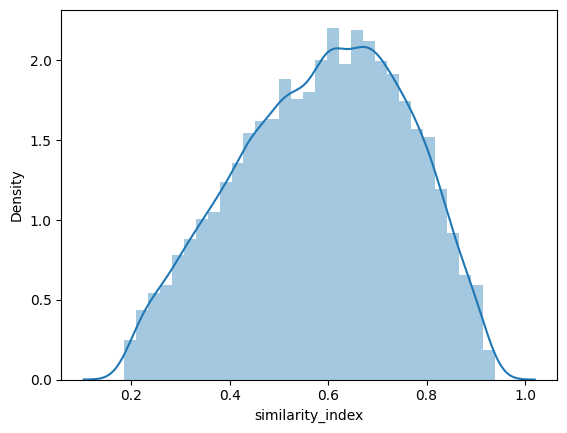

In [10]:
# 평균 유사도 결과 산출
avg_sim = average_similarity(pearson_df, pearson_df.index, 10)
# Distribution Visualization
sns.distplot(avg_sim['similarity_index'])# Dist. viz

In [11]:
# 유사도 평균 분포 확인
avg_sim['similarity_index'].describe()

count    9631.000000
mean        0.587648
std         0.169926
min         0.185166
25%         0.460851
50%         0.600111
75%         0.719810
max         0.938210
Name: similarity_index, dtype: float64

In [12]:
# 유사도 크기 순으로 나열
sim_values = sorted(list(avg_sim['similarity_index']))

# 사용자의 특정 비율에 해당하는 인덱스를 계산
percentiles = [i for i in range(1, 51)]
threshold_indices = [(100 - p) * len(sim_values) // 100 for p in percentiles]
# print(threshold_indices)

# 각 비율에 해당하는 threshold 값을 찾기.
thresholds = [sim_values[len(sim_values)-i] for i in threshold_indices]
# print(thresholds)

In [13]:
# 각 threshold에 대한 사용자 수와 비율을 계산
users_dict = {}

for percentile, threshold in zip(percentiles, thresholds):

    gsu = [user for user, sim in zip(avg_sim['user_id'], avg_sim['similarity_index']) if sim < threshold]

    print(f'Percentile {percentile}% - Threshold: {threshold:.6f}')
    print(f'Number of users below threshold: {len(gsu)}')
    # print(f'Proportion of users below threshold: {len(gsu) / len(avg_sim):.6f}\n')
    # print(f'Users below threshold: {gsu}\n')

    users_dict[f'{percentile}'] = gsu

Percentile 1% - Threshold: 0.219856
Number of users below threshold: 97
Percentile 2% - Threshold: 0.242235
Number of users below threshold: 193
Percentile 3% - Threshold: 0.258459
Number of users below threshold: 289
Percentile 4% - Threshold: 0.276783
Number of users below threshold: 386
Percentile 5% - Threshold: 0.289796
Number of users below threshold: 482
Percentile 6% - Threshold: 0.303560
Number of users below threshold: 578
Percentile 7% - Threshold: 0.315524
Number of users below threshold: 675
Percentile 8% - Threshold: 0.325989
Number of users below threshold: 771
Percentile 9% - Threshold: 0.337108
Number of users below threshold: 867
Percentile 10% - Threshold: 0.347908
Number of users below threshold: 964
Percentile 11% - Threshold: 0.357386
Number of users below threshold: 1060
Percentile 12% - Threshold: 0.366459
Number of users below threshold: 1156
Percentile 13% - Threshold: 0.376244
Number of users below threshold: 1253
Percentile 14% - Threshold: 0.383356
Number o

In [14]:
# Save model results
with open('/home/ryu/thesis/real_amazon/additional_var/1_gsu_data/FM_8_pearson_gsu.pkl', 'wb') as f:
    pickle.dump(users_dict, f)